In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/MyDrive/ColabNotebooks/

/content/gdrive/MyDrive/ColabNotebooks


In [3]:
!ls

data		    lib		       __pycache__     train.py
evaluate.py	    market_simulator   quantGAN.ipynb
hyperparameters.py  numerical_results  sigTrain.ipynb


In [4]:
! pip install esig

In [5]:
pip install tensorflow==1.4

In [6]:
import market_simulator.notebooks.base
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import datetime

from market_simulator.src import market_generator
from market_simulator.src.utils import tosig

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

In [7]:
# Signature order
order = 4

In [8]:
ticker = ['IT']
MG = market_generator.MarketGenerator(ticker, start=datetime.date(1990, 1, 1), end=datetime.date(2008, 4, 30), freq="M", sig_order=order)
MG.data

,IT
Date,
1990-01-02,67.14
1990-01-03,67.29
1990-01-04,67.64
1990-01-05,67.26
1990-01-08,67.75
...,...
2008-04-24,379.46
2008-04-25,375.00
2008-04-28,371.80


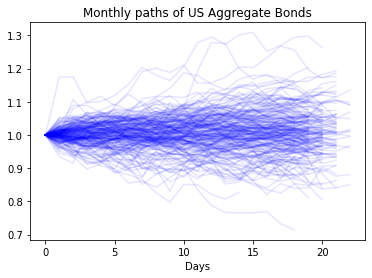

In [9]:
for path in MG.windows:
    returns = path[::2, 1] / path[0, 1] # returns of lead vector
    plt.plot(returns, 'b', alpha=0.1)

plt.title("Monthly paths of US Aggregate Bonds")
plt.xlabel("Days")
plt.show()

In [10]:
MG.train(n_epochs=10000)

In [11]:
generated = np.array([MG.generate(cond) for cond in MG.conditions])

In [12]:
generated_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.orig_logsig[1:])])

100%|██████████| 219/219 [00:04<00:00, 52.87it/s]


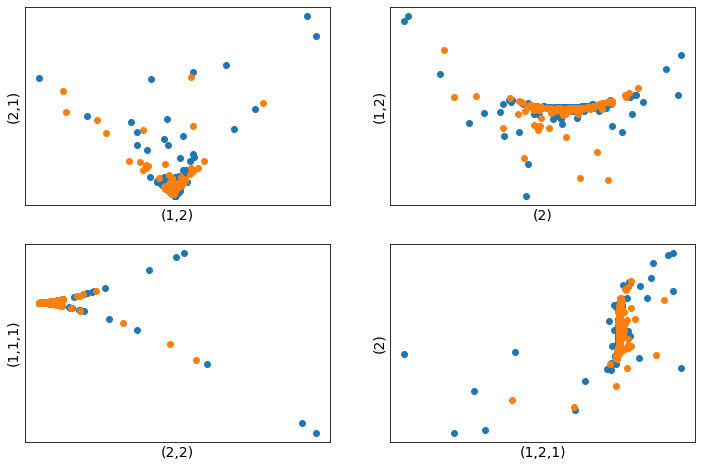

In [13]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

In [14]:
from market_simulator.src import process_discriminator

normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(MG.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

100%|██████████| 219/219 [00:03<00:00, 55.16it/s]



Are the generated and real distributions DIFFERENT? False


## todo 
1. Calibrate discriminator/generator using log-signature, instead of converting back to the signature space and let the process_discriminator perform the two sample tests...
2. Implement test metric in sigGAN
3. Add more data augmentation steps as in sigGAN before applying log-signature transform


In [15]:
#---------- Invert log-signature----------------
from market_simulator.src import logsig_inversion
from esig.tosig import stream2logsig
from market_simulator.src.utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[0])
pip = 0.01
n_pips = 50 * 100 # 50$
n_points = 21

n_iterations = 100
n_organisms = 100

recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

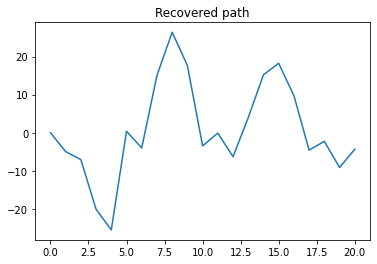

Target log-signature: [-4.375136852264404, -4.773287773132324, -215.15646362304688, -2260.471435546875, -2742.7158203125, 73368.8046875, 171773.09375, 57127.6875]
Recovered log-signature: [-4.320000000000005, -4.320000000000005, -1285.8900999999998, -1903.129096500001, -3835.3809844999996, -113289.52496964164, -159797.89677473274, -84403.34341882165]


In [16]:
plt.plot(recovered_path)
plt.title('Recovered path')
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [17]:
# paths = []
# for condition in MG.conditions:
#     logsig = MG.generate(condition)
#     recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
#                                                   pip, n_pips)
    
#     paths.append(recovered_path)

In [18]:
# import matplotlib.patches as mpatches

# plt.figure(figsize=(8, 6))
# for path1, path2 in zip(paths, MG.windows):
#     returns = path2[::2, 1][:20] - path2[0, 1]
#     plt.plot(returns, "C1", alpha=0.25)

#     plt.plot(path1[:20], "C0", alpha=0.25)
    
    
# blue_patch = mpatches.Patch(color='C0', label='Generated paths')
# red_patch = mpatches.Patch(color='C1', label='Real paths')
# plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
# plt.xlabel("Days", fontsize=14) 
# plt.show()

In [19]:
# returns1 = [path[-1] - path[0] for path in paths]
# returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

# _ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
# plt.xlabel("Monthly return", fontsize=14)
# plt.legend(fontsize=12)
# plt.show()

In [42]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

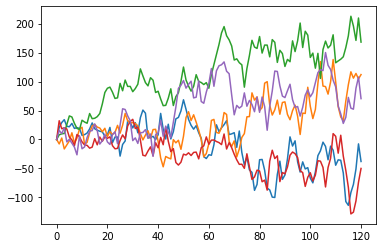

In [43]:
condition = MG.conditions[-1]

paths = [concatenate(condition, 6) for _ in range(5)]

plt.plot(np.transpose(paths))
plt.show()

In [46]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/market_simulator/Capstone.csv').set_index('Date')
df.index = pd.DatetimeIndex(df.index)
start = datetime.date(2008, 5, 1)
end = datetime.date(2008, 10, 31)
test_set = df.loc[start:end, ticker]

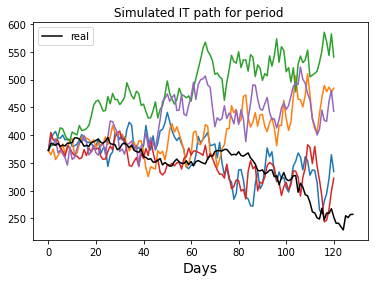

In [48]:
plt.plot(MG.windows[-1][-1,0] + np.transpose(paths))
plt.plot(df.loc['2008-04-30':'2008-10-31', ticker].values,'k', label='real')
plt.xlabel("Days", fontsize=14) 
plt.legend()
plt.title('Simulated IT path for period ')
plt.show()

In [45]:
simulation = pd.DataFrame(MG.windows[-1][-1,0] + np.transpose(paths), columns=['1','2','3','4','5'])
simulation.to_csv('IT_path.csv')